# Atomically thin waveguides based on MoS<sub>2</sub> monolayers

Common waveguides in integrated photonics have a thickness in the order of hundreds of nanometers. However, a novel research `Myungjae Lee et al., Wafer-scale δ waveguides for integrated two-dimensional photonics. Science 381, 648-653(2023)` [DOI:10.1126/science.adi2322](https://www.science.org/doi/10.1126/science.adi2322) demonstrates ultrathin, wafer-scale monolayer molybdenum disulfide (MoS$_2$) waveguides that can efficiently guide visible and near-infrared light over millimeter distances with a low loss. The extreme thickness on the order of a single atom enables light confinement analogous to a quantum mechanical $\delta$-potential well. This allows single-mode, broadband operation unconstrained by conventional waveguide design requirements. Furthermore, microfabricated dielectric and metallic components integrated on the waveguides enable manipulation of the guided waves. Overall, this work establishes a flexible integrated photonics platform using atomically thin two-dimensional materials.

In this notebook, we replicate the key findings from the above publication. We have used the [FastDispersionFitter](../_autosummary/tidy3d.plugins.dispersion.FastDispersionFitter.html) and [Medium2D](../_autosummary/tidy3d.Medium2D.html) features to model the $MoS_{2}$. Our simulations confirmed that the real part of the effective index is approximately equal to the refractive index of the surrounding environment, while the imaginary part follows that of the $MoS_{2}$. Ultra-low loss waveguide mode can be achieved at energies below the bandgap of $MoS_{2}$ when absorption is low. The profile of the waveguide mode is analogous to that of the solution to the $\delta$-potential well in quantum mechanism. We also simulate the propagation of the waveguide mode and visualize its out-coupling into free space, reproducing Fig. 1E in the [publication](https://www.science.org/doi/10.1126/science.adi2322).

<img src="img/MoS2_waveguide.png" width="500" alt="Schematic of the MoS2 waveguide">

For more simulation examples, please visit our [examples page](https://www.flexcompute.com/tidy3d/examples/). If you are new to the finite-difference time-domain (FDTD) method, we highly recommend going through our [FDTD101](https://www.flexcompute.com/fdtd101/) tutorials. FDTD simulations can diverge due to various reasons. If you run into any simulation divergence issues, please follow the steps outlined in our [troubleshooting guide](https://www.flexcompute.com/tidy3d/examples/notebooks/DivergedFDTDSimulation/) to resolve it.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tidy3d as td
import tidy3d.web as web
from tidy3d.plugins.dispersion import FastDispersionFitter, AdvancedFastFitterParam
from tidy3d.plugins.mode import ModeSolver

## Simulation Setup

In our [material library](../material_library.html), we provide a built-in option of [MoS<sub>2</sub>](../material_library.html#molybdenum-disulfide-mos2), which can be used by `MoS2_medium = td.material_library['MoS2']['Li2014']`. However, for maximum consistency, in this notebook we will use the experimentally measured refractive index provided in the [reference](https://www.science.org/doi/10.1126/science.adi2322). The refractive index is stored in a .csv file and we will use the [FastDispersionFitter](../_autosummary/tidy3d.plugins.dispersion.FastDispersionFitter.html) to fit it with the pole residue model. Using 4 pole residue pairs, we are able to fit it very nicely. The fit can be further improved by using even more pole residue pairs, but it is unnecessary in this case. In addition, we can also manipulate the relative weights of the real and imaginar parts of the refractive index. Since in this case, both $n$ and $k$ have the same order of magnitude, we will use the default value `AdvancedFastFitterParam(weights=(1,1))`. 

Output()

[09:55:48] WARNING: Unable to fit with weighted RMS error under  ]8;id=773555;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\plugins\dispersion\fit_fast.py\fit_fast.py]8;;\:]8;id=225279;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\plugins\dispersion\fit_fast.py#843\843]8;;\
           'tolerance_rms' of 0.02                                              

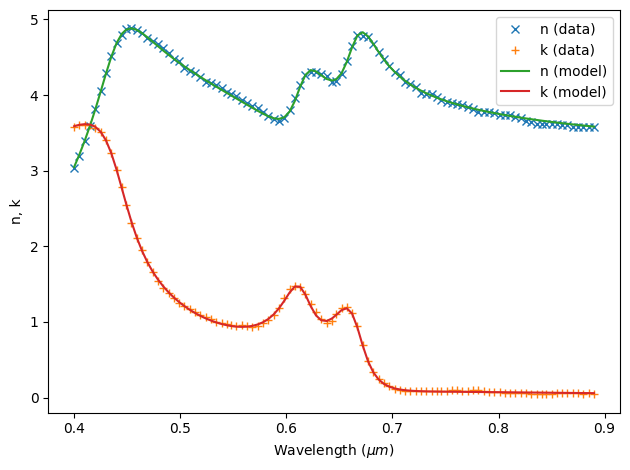

In [2]:
fitter = FastDispersionFitter.from_file('misc/MoS2_nk.csv', skiprows=0, delimiter=",")
advanced_param = AdvancedFastFitterParam(weights=(1,1))
MoS2, rms_error = fitter.fit(max_num_poles=4, advanced_param=advanced_param, tolerance_rms=2e-2)
fitter.plot(MoS2)
plt.show()

The MoS$_2$ medium defined from the fitter is a conventional [Medium](../_autosummary/tidy3d.Medium.html) meant to be used with 3D geometries. Due to the atomically thin nature of MoS$_2$ monolayer, we will be modeling the waveguide as a 2D layer to enjoy the computational cost saving. To do so, we first need to define a [Medium2D](../_autosummary/tidy3d.Medium2D.html) for MoS$_2$, which can be done simply by using the `from_medium` method and providing the thickness of the layer.

In [3]:
t = 0.00065 # thickness of the MoS2 monolayer

# define MoS2 as Medium2D
MoS2_2D = td.Medium2D.from_medium(medium=MoS2, thickness=t)

n_env = 1.46 # refractive index of the environment
env_medium = td.Medium(permittivity=n_env**2) # define environment medium

Define the simulation wavelength range. Here, we are interested in simulating the waveguide response between 500 nm to 900 nm.

In [4]:
lda0 = 0.7  # central wavelength
freq0 = td.C_0 / lda0  # central frequency
ldas = np.linspace(0.5, 0.9, 50)  # wavelength range
freqs = td.C_0 / ldas  # frequency range
fwidth = 0.4*(np.max(freqs) - np.min(freqs)) # width of the source frequency range

Define the waveguide structure.

In [5]:
l = 150 # length of the waveguide

# define the waveguide structure
MoS2_monolayer = td.Structure(geometry=td.Box(center=(0,0,0), size=(l, 0, td.inf)),
                medium=MoS2_2D)


As discussed in the [paper](https://www.science.org/doi/10.1126/science.adi2322), the waveguide mode can be excited by a [PlaneWave](../_autosummary/tidy3d.PlaneWave.html) or a [PointDipole](../_autosummary/tidy3d.PointDipole.html). However, for simulations with a waveguide, the more natural source is a [ModeSource](../_autosummary/tidy3d.ModeSource.html). We will define a [ModeSource](../_autosummary/tidy3d.ModeSource.html) at the begining of the waveguide here and later use the [ModeSolver](../_autosummary/tidy3d.plugins.mode.ModeSolver.html) to investigate the waveguide mode profile and effective index.

In addition, we also defined a [FieldMonitor](../_autosummary/tidy3d.FieldMonitor.html) to help visualize the waveguide mode propagation and out-couple into free space.

In [6]:
# define a mode source
mode_spec = td.ModeSpec(num_modes=1)
mode_source = td.ModeSource(
    size=(0, td.inf, td.inf),
    center=(-l/2+lda0, 0, 0),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    mode_spec=mode_spec,
    mode_index=0,
    direction="+",
    num_freqs=7,  # using 7 (Chebyshev) points to approximate frequency dependence
)

# define a field monitor
field_monitor = td.FieldMonitor(
    center=(0, 0, 0), size=(td.inf, 30, 0), freqs=[freq0], fields=['Ex','Ey','Ez'], interval_space=(1,2,1), name="field"
)

           WARNING: Default value for the field monitor           ]8;id=860062;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\components\monitor.py\monitor.py]8;;\:]8;id=187255;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\components\monitor.py#261\261]8;;\
           'colocate' setting has changed to 'True' in Tidy3D                   
           2.4.0. All field components will be colocated to the                 
           grid boundaries. Set to 'False' to get the raw fields                
           on the Yee grid instead.                                             

Now we are ready to define a Tidy3D [Simulation](../_autosummary/tidy3d.Simulation.html). This is a 2D simulation so the domain size in $z$ is set to 0 and periodic boundary condition is applied in the $z$ boundaries.

In [7]:
Lx = 200 # simulation domain size in the x direction
Ly = 80 # simulation domain size in the y direction
run_time = 1.5e-12 # simulation run time

# construct simulation
sim = td.Simulation(
    center=((Lx-l)/2-lda0, 0, 0),
    size=(Lx,Ly,0),
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=30, wavelength=lda0),
    structures=[MoS2_monolayer],
    sources=[mode_source],
    monitors=[field_monitor],
    run_time=run_time,
    boundary_spec=td.BoundarySpec(
        x=td.Boundary.pml(), y=td.Boundary.pml(), z=td.Boundary.periodic()
    ),
    medium=env_medium,
)


Visualize the simulation to see if it is set up correctly.

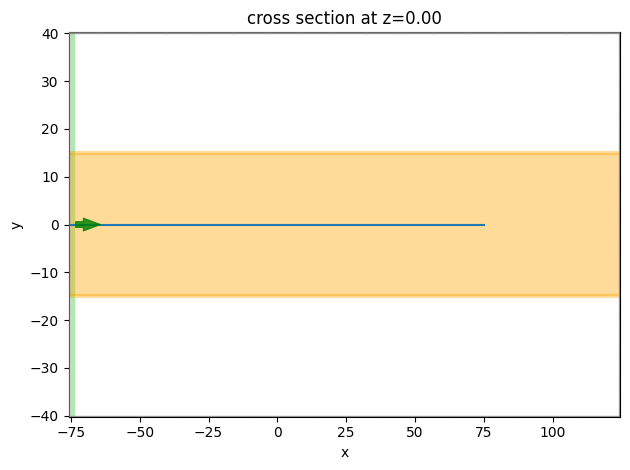

In [8]:
ax = sim.plot(z=0)
ax.set_aspect('auto')

## Perform Mode Solving 

Before running the simulation, we use the [ModeSolver](../_autosummary/tidy3d.plugins.mode.ModeSolver.html) to inspect the waveguide mode profile. The mode solving is performed on the same plane as the [ModeSource](../_autosummary/tidy3d.ModeSource.html) defined ealier.

In [9]:
# define mode solving plane
mode_plane = td.Box(
    center=mode_source.center,
    size=mode_source.size,
)

# define mode solver
mode_solver = ModeSolver(
    simulation=sim, plane=mode_plane, mode_spec=mode_spec, freqs=freqs
)

# solving for the mode
mode_data = mode_solver.solve()

[09:55:49] WARNING: Use the remote mode solver with subpixel  ]8;id=723226;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\plugins\mode\mode_solver.py\mode_solver.py]8;;\:]8;id=761706;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\plugins\mode\mode_solver.py#141\141]8;;\
           averaging for better accuracy through                                
           'tidy3d.plugins.mode.web.run(...)'.                                  

After running the mode solving, let's plot the real part of the effective index, $n_{eff}$, as a function of wavelength. It shows that $n_{eff}$ is constant and equal to the refractive index of the environment medium. This is not suprissing since the MoS$_2$ waveguide is atomically thin so most of the mode field is in the environment medium.

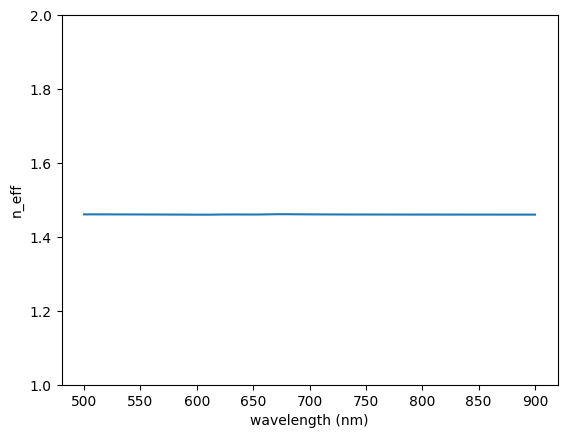

In [10]:
n_eff = np.real(mode_data.n_complex.values)
plt.plot(ldas*1e3, n_eff)
plt.xlabel('wavelength (nm)')
plt.ylabel('n_eff')
plt.ylim(1,2)
plt.show()

Similarly, we can plot the imaginary part of the effective index, $k_{eff}$. The shape of $k_{eff}$ largely follows the imaginary part of the MoS$_2$ refractive index since MoS$_2$ is the only source of loss.

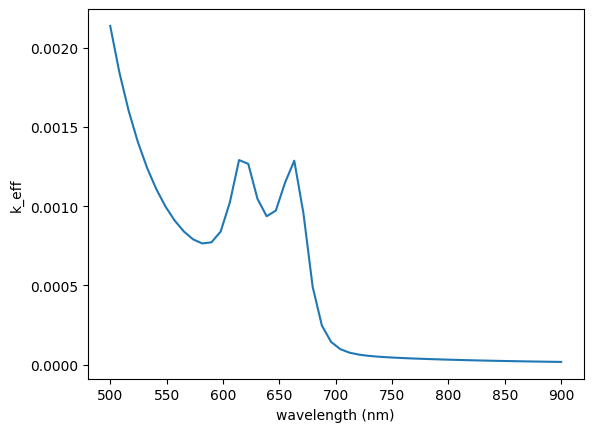

In [11]:
k_eff = np.imag(mode_data.n_complex.values)
plt.plot(ldas*1e3, k_eff)
plt.xlabel('wavelength (nm)')
plt.ylabel('k_eff')
plt.show()

Lastly, we can visualize the mode profiles by plotting the `Ez` component of the mode at different wavelengths. We see that the mode profile resembles that of the solution to the [δ-potential](https://en.wikipedia.org/wiki/Delta_potential) problem in quantum mechanics. We can also observe that the width of the mode increases with wavelength from a few µm at 500 nm to over 10 µm at 900 nm.

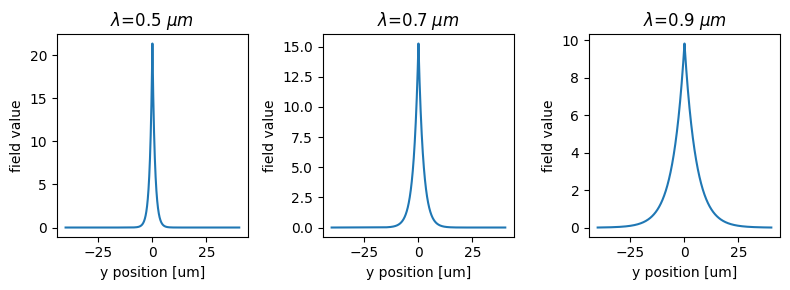

In [12]:
f, (ax1, ax2, ax3) = plt.subplots(
    1, 3, tight_layout=True, figsize=(8, 3)
)
mode_data.Ez.sel(mode_index=0, f=freqs[0]).abs.plot(ax=ax1)
ax1.set_title(f'$\lambda$={ldas[0]} $\mu m$')
mode_data.Ez.sel(mode_index=0, f=freq0, method='nearest').abs.plot(ax=ax2)
ax2.set_title(f'$\lambda$={lda0} $\mu m$')
mode_data.Ez.sel(mode_index=0, f=freqs[-1]).abs.plot(ax=ax3)
ax3.set_title(f'$\lambda$={ldas[-1]} $\mu m$')
plt.show()

## Submit the Simulation 

Now we are ready to submit the simulation to the server. Although this simulation is 2D, the large simulation domain size and the fine grid still results in a good amount of computation. We can expect this simulation to finish in just a minute or two.

In [13]:
sim_data = web.run(
    sim, task_name="mos2_wg", path="data/simulation.hdf5", verbose=True
)

[09:56:04] Created task 'mos2_wg' with task_id                     ]8;id=284593;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=133023;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#188\188]8;;\
           'fdve-e05b98f7-0517-4f67-806a-50cc8ad299b7v1'.                       

           View task using web UI at                               ]8;id=943506;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=418340;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#190\190]8;;\
           ]8;id=875514;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e05b98f7-0517-4f67-806a-50cc8ad299b7v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=269545;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e05b98f7-0517-4f67-806a-50cc8ad299b7v1\taskId]8;;\]8;id=875514;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e05b98f7-0517-4f67-806a-50cc8ad299b7v1\=]8;;\]8;id=910795;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e05b98f7-0517-4f67-806a-50cc8ad299b7v1\fdve]8;;\]8;id=875514;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e05b98f7-0517-4f67-806a-50cc8ad299b7v1\-]8;;\              
           ]8;id=875514;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e05b98f7-0517-4f67-806a-50cc8ad299b7v1\e05b98f7-0517-4f67-806a-50cc8ad299b7v1']8;;\.                             

Output()

[09:56:06] status = queued                                         ]8;id=443272;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=265742;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#361\361]8;;\

Output()

[09:56:10] status = preprocess                                     ]8;id=392319;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=99695;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#355\355]8;;\

[09:56:15] Maximum FlexCredit cost: 0.890. Use                     ]8;id=337726;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=789677;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#341\341]8;;\
           'web.real_cost(task_id)' to get the billed FlexCredit                
           cost after a simulation run.                                         

           starting up solver                                      ]8;id=402560;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=277843;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#377\377]8;;\

           running solver                                          ]8;id=387250;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=451993;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#386\386]8;;\

           To cancel the simulation, use 'web.abort(task_id)' or   ]8;id=66882;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=577034;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#387\387]8;;\
           'web.delete(task_id)' or abort/delete the task in the                
           web UI. Terminating the Python script will not stop the              
           job running on the cloud.                                            

Output()

[10:00:35] early shutoff detected, exiting.                        ]8;id=700433;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=844775;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#404\404]8;;\

[10:00:36] status = postprocess                                    ]8;id=507698;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=427428;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#420\420]8;;\

Output()

[10:01:03] status = success                                        ]8;id=79537;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=330362;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#427\427]8;;\

Output()

[10:01:11] loading SimulationData from data/simulation.hdf5        ]8;id=28627;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=70796;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\web\webapi.py#591\591]8;;\

## Visualize the Result

After the simulation is complete, we can plot the field distribution to visualize the waveguide mode propagation in the MoS$_2$ and out couples to free space in the end. The field stays guided when propagating on MoS$_2$ and starts to diverge after entering the free space. The result is consistent with Fig. 1E in the [publication](https://www.science.org/doi/10.1126/science.adi2322).

[10:01:13] WARNING: Evaluating permittivity of a 'Medium2D' is    ]8;id=318566;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\components\medium.py\medium.py]8;;\:]8;id=276334;file://C:\Users\xinzhong\Desktop\tidy3d\tidy3d\components\medium.py#3582\3582]8;;\
           unphysical.                                                          

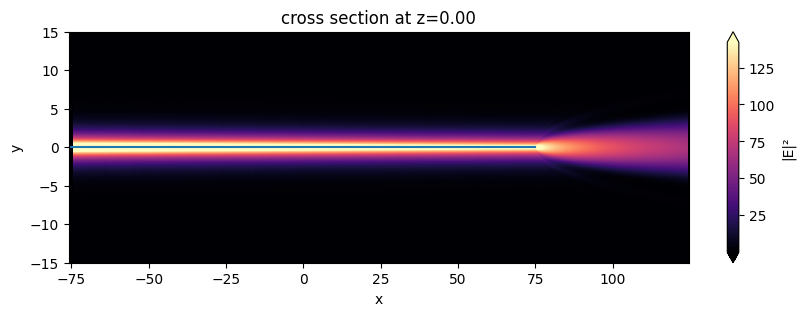

In [14]:
fig, ax = plt.subplots(figsize=(10,3))
sim_data.plot_field(field_monitor_name='field', field_name='E', val='abs^2', ax=ax)
ax.set_aspect('auto')
plt.show()

In conclusion, the discussed method for creating 2D material waveguides can be applied to various atomically thin materials, enabling ultra-slim photonic circuits. These waveguides can guide a broad spectrum of light, making them versatile for multi-octave photonic systems. They also offer high-power, dispersion-free operation, ideal for 2D nonlinear photonics and pulse manipulation. 